# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-win48-dyaw'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18692, 18084)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 9]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 9])

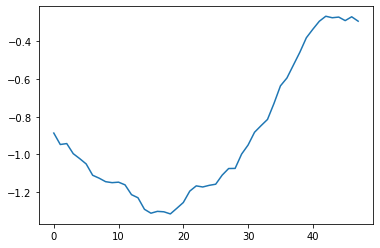

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=9, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  19.209743
 - Pitch        :   9.771925
 - Roll         :   2.592726
 - RMS          :  12.532983
 - 99% Tile     :  43.777800
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  16.106802
 - Pitch        :   8.863819
 - Roll         :   2.550051
 - RMS          :  10.716018
 - 99% Tile     :  40.351911
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.683007
 - Pitch        :   8.963748
 - Roll         :   2.374054
 - RMS          :   9.070898
 - 99% Tile     :  34.760177
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.075305
 - Pitch        :   8.204325
 - Roll         :   2.330022
 - RMS          :   7.621280
 - 99% Tile     :  31.390526
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.789800
 - Pitch        :   7.549289
 - Roll         :   2.403988
 - RMS          :   6.832069
 - 99% Tile     :  28.710189
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.329851
 - Pitch        :   7.546861
 - Roll         :   2.365058
 - RMS          :   6.225628
 - 99% Tile     :  26.334857
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.657001
 - Pitch        :   7.258316
 - Roll         :   2.346135
 - RMS          :   5.845316
 - 99% Tile     :  24.795121
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   8.202377
 - Pitch        :   6.850206
 - Roll         :   2.252542
 - RMS          :   6.305507
 - 99% Tile     :  24.089116
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.184114
 - Pitch        :   6.915474
 - Roll         :   2.362997
 - RMS          :   5.173090
 - 99% Tile     :  21.767211
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.620204
 - Pitch        :   6.803865
 - Roll         :   2.365645
 - RMS          :   5.274958
 - 99% Tile     :  21.600684
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.671196
 - Pitch        :   6.804782
 - Roll         :   2.336627
 - RMS          :   4.663424
 - 99% Tile     :  21.373904
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.246171
 - Pitch        :   6.775745
 - Roll         :   2.322053
 - RMS          :   4.540201
 - 99% Tile     :  21.050409
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.297427
 - Pitch        :   6.795160
 - Roll         :   2.297639
 - RMS          :   4.558010
 - 99% Tile     :  20.398626
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   4.199894
 - Pitch        :   6.850503
 - Roll         :   2.272407
 - RMS          :   4.821215
 - 99% Tile     :  20.241784
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.060460
 - Pitch        :   6.391116
 - Roll         :   2.282912
 - RMS          :   4.298235
 - 99% Tile     :  20.911318
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.732839
 - Pitch        :   6.352597
 - Roll         :   2.320167
 - RMS          :   4.211376
 - 99% Tile     :  21.424033
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.732368
 - Pitch        :   6.415394
 - Roll         :   2.287157
 - RMS          :   4.236909
 - 99% Tile     :  20.296408
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.846525
 - Pitch        :   6.475384
 - Roll         :   2.260081
 - RMS          :   4.539982
 - 99% Tile     :  20.748587
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.428312
 - Pitch        :   5.218237
 - Roll         :   2.281479
 - RMS          :   3.574533
 - 99% Tile     :  18.824785
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   9.742020
 - Pitch        :   5.004798
 - Roll         :   2.215424
 - RMS          :   6.451436
 - 99% Tile     :  22.077821
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.732370
 - Pitch        :   3.545023
 - Roll         :   2.331710
 - RMS          :   2.913755
 - 99% Tile     :  12.611335
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.885472
 - Pitch        :   2.285245
 - Roll         :   2.318101
 - RMS          :   2.171861
 - 99% Tile     :  10.609366
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.808510
 - Pitch        :   3.402348
 - Roll         :   2.250258
 - RMS          :   3.222027
 - 99% Tile     :  11.042539
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.305772
 - Pitch        :   2.244734
 - Roll         :   2.266134
 - RMS          :   2.272354
 - 99% Tile     :  10.162861
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.447680
 - Pitch        :   1.752983
 - Roll         :   2.292424
 - RMS          :   1.864040
 - 99% Tile     :   9.837710
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.940975
 - Pitch        :   1.730606
 - Roll         :   2.334941
 - RMS          :   2.017782
 - 99% Tile     :   9.384616
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.180368
 - Pitch        :   2.635745
 - Roll         :   2.297062
 - RMS          :   2.378911
 - 99% Tile     :   9.527317
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.222679
 - Pitch        :   1.518330
 - Roll         :   2.299434
 - RMS          :   1.740466
 - 99% Tile     :   8.730096
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.598503
 - Pitch        :   1.535146
 - Roll         :   2.313037
 - RMS          :   2.195376
 - 99% Tile     :   8.876660
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.399213
 - Pitch        :   1.525451
 - Roll         :   2.273743
 - RMS          :   2.101835
 - 99% Tile     :   8.539810
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.432126
 - Pitch        :   1.369385
 - Roll         :   2.312315
 - RMS          :   1.758124
 - 99% Tile     :   7.798909
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.948110
 - Pitch        :   3.013310
 - Roll         :   2.319678
 - RMS          :   2.466852
 - 99% Tile     :   9.554904
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.952523
 - Pitch        :   1.650382
 - Roll         :   2.231426
 - RMS          :   1.959198
 - 99% Tile     :   8.116339
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.434284
 - Pitch        :   1.263337
 - Roll         :   2.257783
 - RMS          :   1.707900
 - 99% Tile     :   7.830381
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.741438
 - Pitch        :   1.224289
 - Roll         :   2.248323
 - RMS          :   1.787591
 - 99% Tile     :   7.049496
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.790079
 - Pitch        :   1.285720
 - Roll         :   2.288980
 - RMS          :   1.834565
 - 99% Tile     :   9.093356
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.442652
 - Pitch        :   1.098841
 - Roll         :   2.294741
 - RMS          :   2.036323
 - 99% Tile     :   8.052335
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.540420
 - Pitch        :   1.170882
 - Roll         :   2.285435
 - RMS          :   1.728879
 - 99% Tile     :   7.023577
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.115345
 - Pitch        :   0.942937
 - Roll         :   2.282719
 - RMS          :   1.564601
 - 99% Tile     :   6.709484
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.635711
 - Pitch        :   1.185884
 - Roll         :   2.265275
 - RMS          :   1.752460
 - 99% Tile     :   6.976535
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   3.504753
 - Pitch        :   1.204793
 - Roll         :   2.245925
 - RMS          :   2.501933
 - 99% Tile     :  10.341858
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.683779
 - Pitch        :   1.296105
 - Roll         :   2.302834
 - RMS          :   1.809055
 - 99% Tile     :   7.349976
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.789588
 - Pitch        :   0.908284
 - Roll         :   2.315361
 - RMS          :   1.769039
 - 99% Tile     :   7.034938
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.271496
 - Pitch        :   1.077467
 - Roll         :   2.249604
 - RMS          :   1.616411
 - 99% Tile     :   7.418052
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.989761
 - Pitch        :   1.843498
 - Roll         :   2.216100
 - RMS          :   2.022270
 - 99% Tile     :   7.169510
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.441751
 - Pitch        :   1.268240
 - Roll         :   2.255821
 - RMS          :   1.710342
 - 99% Tile     :   9.345854
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   2.684998
 - Pitch        :   1.245360
 - Roll         :   2.266943
 - RMS          :   2.152453
 - 99% Tile     :   7.848085
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   1.285507
 - Pitch        :   1.044345
 - Roll         :   2.257727
 - RMS          :   1.616634
 - 99% Tile     :   7.892662
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0048.npy


[0049/0100] Validation: 100%|██████████████████████| 71/71 [00:02<00:00, 24.19it/s, val_loss 5.3854]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   1.496019
 - Pitch        :   1.157190
 - Roll         :   2.255248
 - RMS          :   1.699344
 - 99% Tile     :   7.565107
Save output signals into checkpoint/1122-Scene3-CLSTM2-win48-dyaw/sample/0049.npy
